In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d 
import scipy
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import sklearn, xgboost, uproot
from scipy import stats
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_curve,roc_auc_score
from sklearn.ensemble import AdaBoostClassifier
# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import JFuncs
import umap
import dill
from numpy import logical_and as npand
import shap
import warnings
import JohannFunctions as nnfuncs
import hep_ml
from hep_ml.uboost import uBoostClassifier

warnings.filterwarnings('ignore')
# sns.set()
sns.reset_orig()
# %matplotlib inline


def hist(dat,bins=100,ax = None):
    if(ax==None):
        fig,ax = plt.subplots(figsize=(10,5))
    ax.hist(dat,bins,histtype="step")
def hists(dats,bins=100):
    plt.figure(figsize=(10,5))
    for d in dats:
        plt.hist(d,bins,histtype="step")
    
def tf(d):
    return d[dat["trueKs"].astype(bool)],d[~dat["trueKs"].astype(bool)]

    

def preprocess(l):
    return (l-np.mean(l))/np.std(l)
shapval = "cosTheta v0_ks_mass pT v0_rxyErr v0_rxy v0_chi2 ntrk_pv0 eventCounter a0 a0xy pv0_y calpha v0_ks_massErr epsilon1 epsilon2 v0_ptErr v0_p v0_pz1 v0_phi2 v0_y".split(" ")
mass_uncorrelated = ["v0_chi2","v0_px1","v0_phi1","v0_py1","v0_py","v0_py2","v0_phi2","v0_px2","v0_px"]


In [3]:
bigDat = True

if bigDat:
    path = "CernData/mc15_13TeV.361203.Pythia8_A2_MSTW2008LO_ND_minbias.30062015_v0_per_0.root"
    dat_amount = 2*1e6

    file = uproot.open(path)
    tree = file['tree']
    dat = tree.pandas.df(shapval+["trueKs"], entrystop=dat_amount)
    df_all = tree.pandas.df(entrystop = dat_amount)
    moredat = tree.pandas.df(shapval+["trueKs"], entrystop=2*dat_amount)
    moredat = moredat[int(dat_amount):]
else:
    path = "dataframe_v0_mc.dat"
    dat = pd.read_pickle(path)


# print([head for head in dat])

In [4]:
if True:
    path = "CernData/data15_13TeV.00267358.physics_MinBias.30062015_v0_per_0.root"
    dat_amount = 1e12

    file = uproot.open(path)
    tree = file['tree']
    truedat = tree.pandas.df(shapval, entrystop=dat_amount)


In [5]:
def logit(x):
    return np.log(x/(1-x))

## Simple fit

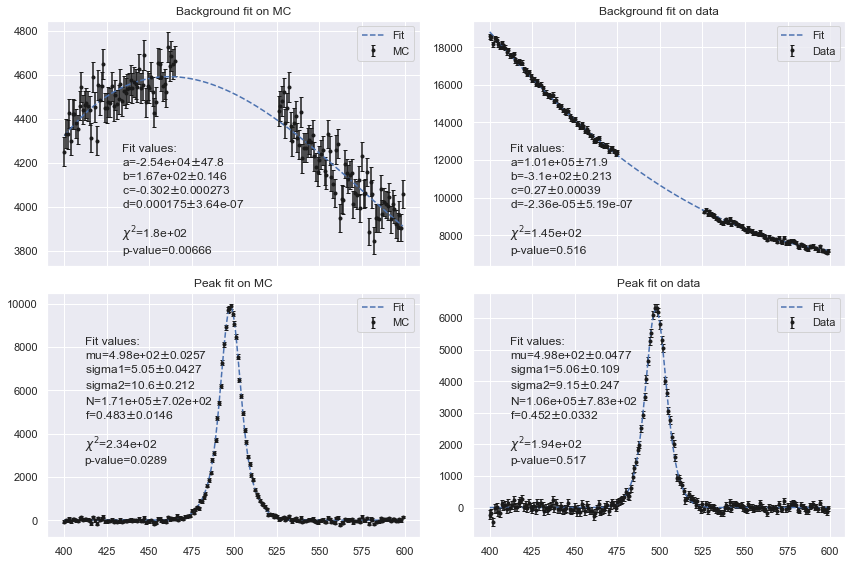

In [11]:
off = 0
bg = lambda x,a,b,c,d: np.polynomial.polynomial.polyval(x,[a,b,c,d])
def doublegauss(x,mu,sigma1,sigma2,N,f):
    return N*(stats.norm.pdf(x,mu,sigma1)*f + stats.norm.pdf(x,mu,sigma2)*(1-f))

def sg(x,mu,sigma,s):
    return s*stats.norm.pdf(x,mu,sigma)+off
fig, axs = plt.subplots(2,2,figsize=(12,8),sharex=True)

axs = axs.flatten()

full = lambda x,a,b,c,d,mu,sigma1,sigma2,s,f: doublegauss(x,mu,sigma1,sigma2,s,f)+np.polynomial.polynomial.polyval(x,[a,b,c,d])

#MC

amount = int(6*1e6)
d = dat[:amount]
rng = np.logical_and(d['v0_ks_mass']>400,d['v0_ks_mass']<600)
y,x = np.histogram(d[rng]['v0_ks_mass'],200) 
x = x[:-1]

lt = np.logical_or(x<466,x>525)
yerrs = np.sqrt(y)
mi,ax = JFuncs.chi2fit(x[lt],y[lt],yerrs[lt],bg,{"a":-1,"b":1,"c":1,"d":350},ax=axs[0],draw=True,label="MC",text=(0.2,0.05))
y -= bg(x,*mi.args).astype(int)-off

guess = scipy.optimize.curve_fit(sg, x, y, p0 = [497, 4, 500])[0]
mu, sigma, s = guess
mi,ax = JFuncs.chi2fit(x,y,yerrs,doublegauss,{"mu":mu,"sigma1":sigma,"sigma2":2*sigma,"N":s,"f":0.1},ax=axs[2],draw=True,label="MC",text=(0.1,0.3))
# mi,ax = JFuncs.chi2fit(x,y,yerrs,sg,{"mu":mu,"sigma":sigma,"s":N},ax=axs[1],draw=True,label="MC",)


#data
d = truedat[:amount]
rng = np.logical_and(d['v0_ks_mass']>400,d['v0_ks_mass']<600)
y,x = np.histogram(d[rng]['v0_ks_mass'],200) 
x = x[:-1]

lt = np.logical_or(x<475,x>525)
yerrs = np.sqrt(y)
mi,ax = JFuncs.chi2fit(x[lt],y[lt],yerrs[lt],bg,{"a":-1,"b":1,"c":1,"d":350},ax=axs[1],draw=True,label="Data",text=(0.1,0.05))
y -= bg(x,*mi.args).astype(int)-off

guess = scipy.optimize.curve_fit(sg, x, y, p0 = [497, 4, 500])[0]
mu, sigma, s = guess
mi,ax = JFuncs.chi2fit(x,y,yerrs,doublegauss,{"mu":mu,"sigma1":sigma,"sigma2":2*sigma,"N":s,"f":0.1},ax=axs[3],draw=True,label="Data",text=(0.1,0.3))


axs[0].set_title("Background fit on MC")
axs[1].set_title("Background fit on data")
axs[2].set_title("Peak fit on MC")
axs[3].set_title("Peak fit on data")



# mi,ax = JFuncs.chi2fit(x,y,yerrs,sg,{"mu":mu,"sigma":sigma,"s":N},ax=axs[1],draw=True,label="MC",)
fig.tight_layout()
plt.show()

<function JohannFunctions.roc_curve_data(mass, probs, Npoints=10, bins=100, range=(400, 600), ax_roc=None, ax_fits=None, verbose=True, plimit=0.01, ax_hist=None)>

## not so simple everything else

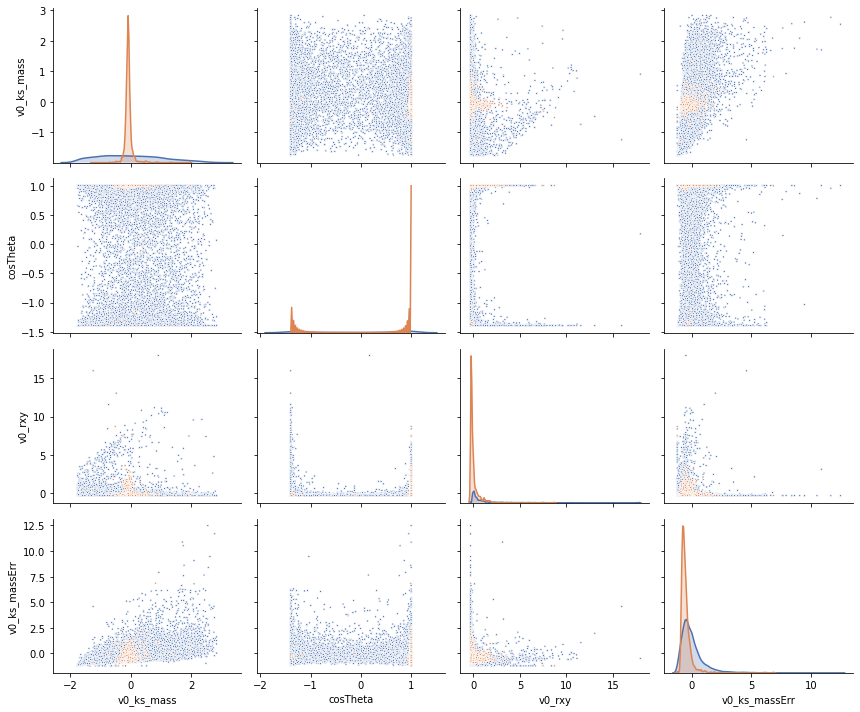

In [51]:
pva0 = "v0_ks_mass cosTheta v0_rxy v0_ks_massErr trueKs".split(" ")

pg = sns.pairplot(preprocess(dat[pva0][:10000]),hue="trueKs",diag_kind="kde",plot_kws=dict(marker=".", size=4),palette=sns.color_palette("deep"))

pg._legend.remove()
plt.tight_layout()

1 81821.0
2 46744.0
3 3928.0
4 2089.0
1 83927.0
2 48865.0
3 5473.0
4 3079.0
Made UMAP
Fittet UMAP
Transformed UMAP


C:\Users\jakob\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


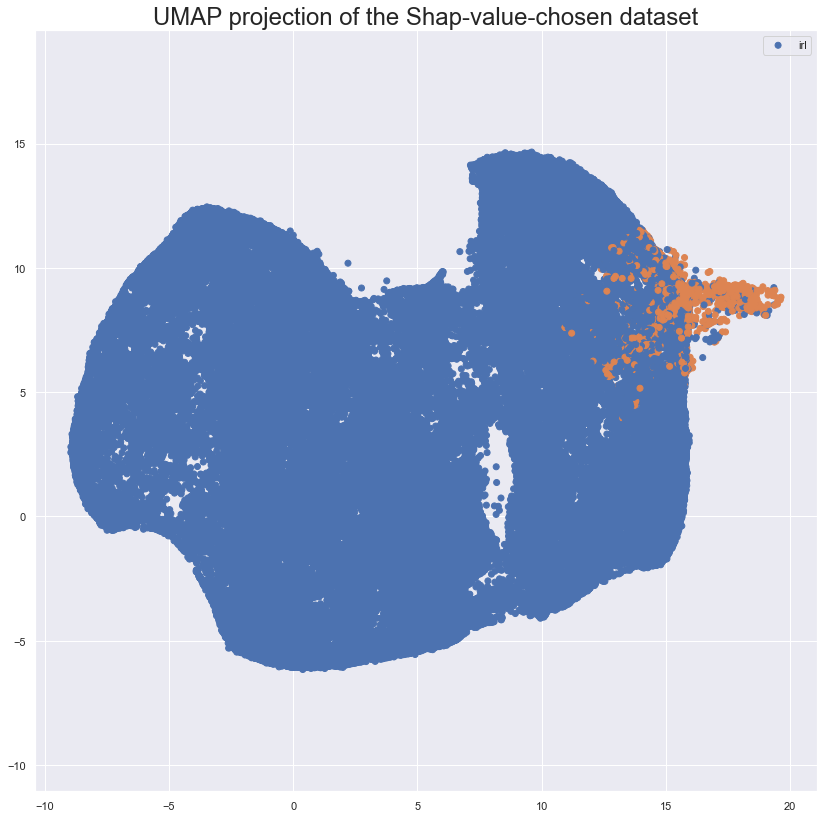

Plottet UMAP


In [34]:
rxy_low_min, rxy_high_min, chi2_high_min, cos_Theta_low_min, mass_low_min, mass_high_min = -60.818,114.783,3.782,0.9976,450,550
#tak nn
def cutter(df):
    label = np.ones(len(df))
    label[np.logical_or(df['v0_rxy'] < rxy_low_min, df['v0_rxy'] > rxy_high_min)] = 0
    print(1,sum(label))
    label[df['v0_chi2'] > chi2_high_min] = 0
    print(2,sum(label))
    
    label[df['cosTheta'] < cos_Theta_low_min] = 0
    print(3,sum(label))
    
    label[np.logical_or(df['v0_ks_mass'] < mass_low_min, df['v0_ks_mass'] > mass_high_min)] = 0
    print(4,sum(label))
    
    return label



ps = "v0_rxy v0_chi2 cosTheta v0_ks_mass".split(" ")

amount = int(1e5)

td = (truedat[ps])[:amount]

td_test = (truedat[ps])[amount:int(amount*2)]

target = cutter(td).astype(bool)#pd.Series(cutter(td), dtype = bool)

test_target = cutter(td_test).astype(bool)#pd.Series(cutter(td_test), dtype = bool)

td,td_test = preprocess(td),preprocess(td_test)
# dn = preprocess(dat[gg]).dropna()[:amount]




# target = dat["trueKs"][:amount]

# sns.pairplot(preprocess(dat[shap[:7]+["trueKs"]]), hue='trueKs')#,palette='Pastel1')
# plt.plot()
reducer = umap.UMAP(n_neighbors=20)

print("Made UMAP")

mapper = reducer.fit(td)

print("Fittet UMAP")

tembedding = mapper.transform(td_test)


print("Transformed UMAP")

# print(embedding.shape)


plt.figure(figsize=(14,14))
plt.scatter(
    tembedding[:, 0],
    tembedding[:, 1],
    c=[sns.color_palette()[x] for x in test_target],
    cmap='Spectral',
#     marker = '*',
#     s=5,
    alpha=1,
    label="irl"
    )

# plt.scatter(
#     tembedding[:, 0],
#     tembedding[:, 1],
# #     c=[sns.color_palette()[x] for x in target],
#     c='red',
#     s=0.1,
#     label="irl"
#     )



# Ks = mapper.transform(preprocess(dat[dat["trueKs"].astype(bool)][gg]).dropna())
# plt.scatter(
#     Ks[:, 0],
#     Ks[:, 1],
#     c="red",
#     marker = '*',
#     s=0.1
#     )


plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Shap-value-chosen dataset', fontsize=24)
plt.legend()
plt.show()
print("Plottet UMAP")


In [186]:
params = "cosTheta pT v0_rxyErr v0_rxy v0_chi2 ntrk_pv0 a0 a0xy pv0_y calpha v0_ks_massErr epsilon1 epsilon2 v0_ptErr v0_p v0_pz1 v0_phi2 v0_y".split(" ")


s = int(4*1e4)
d = preprocess(dat[:s][params])
td = preprocess(truedat[:s][params])

target = dat[:s]["trueKs"]

reducer = umap.UMAP(n_components=2,n_neighbors=20,transform_seed=420)


allesammen = pd.concat([d,td])

print("Made UMAP")



te = reducer.fit(d,target)
print("Fittet UMAP")


# print(embedding.shape)




Made UMAP
Fittet UMAP


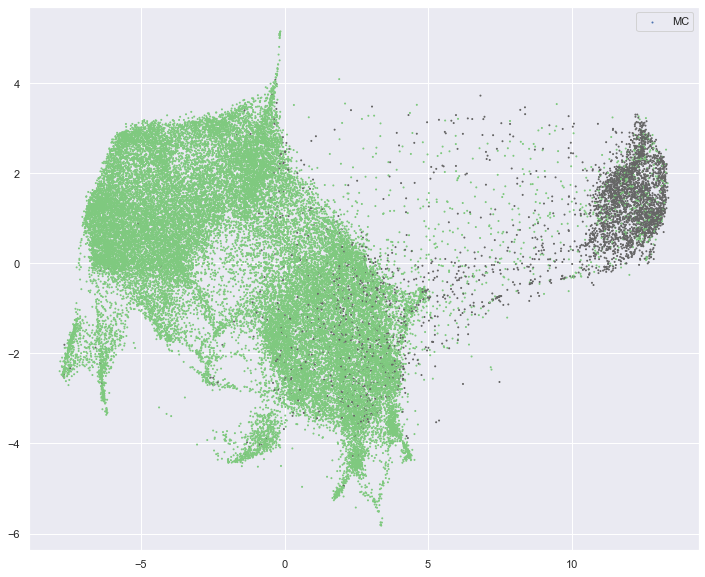

In [167]:


dd = preprocess(dat[s:2*s][params])

# cs = dat[s:2*s]["trueKs"]



plt.figure(figsize=(12,10))

# t = te.transform(dd)
# cs = dat[s:2*s]["trueKs"]
# plt.scatter(
#     t[:, 0],
#     t[:, 1],
#     alpha=0.8,
#     cmap='viridis',
#     c=cs,
#     label="MC",
#     s=0.8,
#     marker="o"

#     )


ddd = preprocess(dat[s:s*2][params])
t = te.transform(ddd)
# t = te.transform(td)

# y_pred = model.predict_proba(td[ps])
# cs = y_pred[:,0]<0.4
cs = dat[s:s*2]["trueKs"]
plt.scatter(
    t[:, 0],
    t[:, 1],
    cmap='Accent',
    alpha=1,
    c=cs,
    label="MC",
    s=1,

    )
# plt.colorbar()
plt.legend()
plt.show()

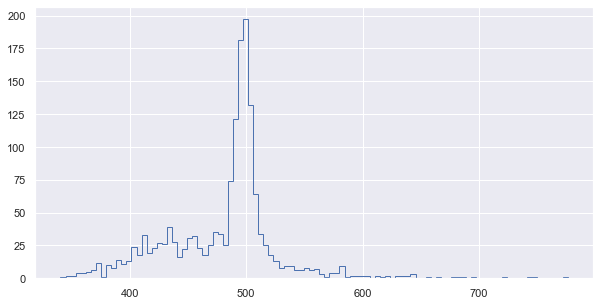

In [165]:
hist(truedat[:s][t[:, 0]>5]["v0_ks_mass"],100)

## UBoost testing with Jones

In [15]:
params = "cosTheta pT v0_rxyErr v0_rxy v0_chi2 ntrk_pv0 a0 a0xy pv0_y calpha v0_ks_massErr epsilon1 epsilon2 v0_ptErr v0_p v0_pz1 v0_phi2 v0_y".split(" ")


s = int(4*1e4)
d = preprocess(dat[:s][params])
t1 = dat[:s]["trueKs"]



reducer = umap.UMAP(n_components=len(params)-1,n_neighbors=20,transform_seed=420)



print("Made UMAP")



te = reducer.fit(d,t1)
print("Fittet UMAP")


# print(embedding.shape)




Made UMAP
Fittet UMAP


In [16]:
size = len(dat)

dd = preprocess(dat[2*s:size][params])
t2 = dat[2*s:size]["trueKs"]

trans = te.transform(dd)

print("transformed")
umodel = xgboost.XGBClassifier(learning_rate = 0.1,n_estimators = 50)
model  = xgboost.XGBClassifier(learning_rate = 0.1,n_estimators = 50)

umodel.fit(trans, t2,verbose=True,eval_metric ="auc")
print("fittet1")
model.fit(dd, t2,verbose=True,eval_metric ="auc")
print("fittet2")



transformed
fittet1
fittet2


uBoost:
Completed fit with Chi2: 132.7, p-val: 0.003 and the total amount of signal 7802 +/- 133, background: 92198
Completed fit with Chi2: 88.4, p-val: 0.558 and the total amount of signal 966 +/- 77, background: 89034
Completed fit with Chi2: 89.1, p-val: 0.536 and the total amount of signal 464 +/- 85, background: 79537
Completed fit with Chi2: 80.0, p-val: 0.787 and the total amount of signal 268 +/- 64, background: 69733
Completed fit with Chi2: 75.2, p-val: 0.884 and the total amount of signal 199 +/- 125, background: 59801
Completed fit with Chi2: 74.0, p-val: 0.902 and the total amount of signal 140 +/- 50, background: 49860
Completed fit with Chi2: 76.7, p-val: 0.858 and the total amount of signal 73 +/- 58, background: 39928
Completed fit with Chi2: 99.4, p-val: 0.257 and the total amount of signal 89 +/- 31, background: 29911
Completed fit with Chi2: 94.6, p-val: 0.377 and the total amount of signal 43 +/- 41, background: 19958
Completed fit with Chi2: 97.1, p-val: 0.312 an

Text(0.5, 1.0, 'Boring Boost')

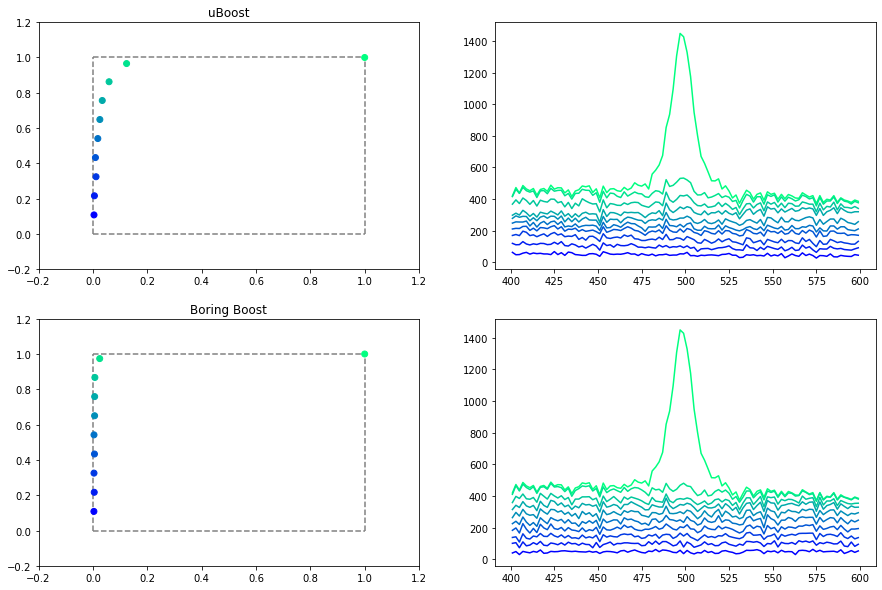

In [18]:
amount = int(1e5)

test_data = moredat[:amount][params]

processed = preprocess(test_data)
transformed = te.transform(processed)

utf = umodel.predict_proba(transformed)
tf = model.predict_proba(processed)



fig, axs = plt.subplots(2,2,figsize=(15,10))

print("uBoost:")
nnfuncs.roc_curve_data(moredat[:amount]["v0_ks_mass"],utf[:,0],ax_roc=axs[0,0],ax_fits=axs[0,1],)
print("Boring Boost:")
nnfuncs.roc_curve_data(moredat[:amount]["v0_ks_mass"],tf[:,0],ax_roc=axs[1,0],ax_fits=axs[1,1])

axs[0,0].set_title("uBoost")
axs[1,0].set_title("Boring Boost")



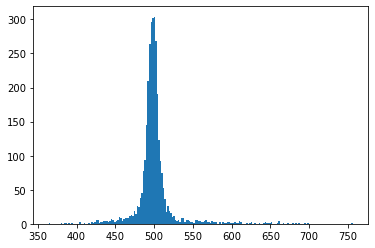

In [37]:
tfbool = tf[:,0]<0.4

amount = tfbool==t3

plt.hist(dat[s:2*s][tfbool]["v0_ks_mass"],200)
plt.show()

In [ ]:
cosmask = truedat["cosTheta"]>0.997

massk = np.logical_and(truedat["v0_ks_mass"]>400,truedat["v0_ks_mass"]<600)

msk = np.logical_and(cosmask,massk)
t,f = truedat["v0_ks_mass"][msk],truedat["v0_ks_mass"][~msk]


hist(t,200)

y,x = np.histogram(t,200)

bg = lambda x,a,b: x*a+b
func = lambda x,mu,sigma,a,b: stats.norm.pdf(x,mu,sigma)*a+b

fig, ax = plt.subplots(figsize=(13,6))
x = x[:-1]
mi,ax = JFuncs.chi2fit(x,y,np.sqrt(y),bg,{"a":100,"b":80},ax=ax,text=(.1,.4))
plt.show()
fig, ax = plt.subplots(figsize=(13,6))

y = y.astype(float)-bg(x,*mi.args)+500
JFuncs.chi2fit(x,y,np.sqrt(y),func,{"mu":490,"sigma":3,"a":2400,"b":10},ax=ax,text=(.1,.4))
plt.show()


## trying the imposter-uBoost

In [14]:
Johanns_decorr = "v0_chi2 v0_px1 v0_phi1 v0_py1 v0_py v0_py2 v0_phi2 v0_px2 v0_px cosTheta a0xy a0 v0_y v0_x v0_rxyErr v0_z pv0_z pv0_y ntrk_pv0 pv0_x".split(" ")

In [16]:
d = df_all[:int(1e3)]
train_data, train_labels = d[allparams],d["trueKs"]

base_tree = AdaBoostClassifier(n_estimators=50, random_state=0)
clf = uBoostClassifier(uniform_features = ['v0_ks_mass'], uniform_label=0, base_estimator=base_tree,train_features=allparams,random_state=420)
clf.fit(train_data, train_labels)


uBoostClassifier(base_estimator=AdaBoostClassifier(random_state=0),
                 random_state=420, smoothing=0.5,
                 train_features=['eventCounter', 'npv', 'ntrk_pv0', 'pv0_x',
                                 'pv0_y', 'pv0_z', 'a0xy', 'a0', 'a0z',
                                 'cosTheta', 'v0_chi2', 'v0_x', 'v0_y', 'v0_z',
                                 'v0_rxy', 'v0_rxyErr', 'v0_px', 'v0_py',
                                 'v0_pz', 'v0_pt', 'v0_p', 'v0_ptErr',
                                 'v0_ks_mass', 'v0_la_mass', 'v0_lb_mass',
                                 'v0_ks_massErr', 'v0_la_massErr',
                                 'v0_lb_massErr', 'v0_px1', 'v0_py1', ...],
                 uniform_features=['v0_ks_mass'], uniform_label=0)

In [17]:
d = df_all[int(1e5):int(1e6)]
train_data, train_labels = d[allparams],d["trueKs"]

xgmodel = AdaBoostClassifier(n_estimators=100, random_state=0)
xgmodel.fit(train_data[Johanns_decorr], train_labels)


AdaBoostClassifier(n_estimators=100, random_state=0)

In [18]:
bad = np.append(Johanns_decorr,"v0_ks_mass")
d = df_all[:int(1e4)]
train_data, train_labels = d[bad],d["trueKs"]
test_data = d[int(1e4):2*int(1e4)]
base_tree = AdaBoostClassifier(n_estimators=50, random_state=0)
clf_bad = uBoostClassifier(uniform_features = ['v0_ks_mass'], uniform_label=0, base_estimator=base_tree,train_features=bad,random_state=420)
clf_bad.fit(train_data, train_labels)

uBoostClassifier(base_estimator=AdaBoostClassifier(random_state=0),
                 random_state=420, smoothing=0.5,
                 train_features=array(['v0_chi2', 'v0_px1', 'v0_phi1', 'v0_py1', 'v0_py', 'v0_py2',
       'v0_phi2', 'v0_px2', 'v0_px', 'cosTheta', 'a0xy', 'a0', 'v0_y',
       'v0_x', 'v0_rxyErr', 'v0_z', 'pv0_z', 'pv0_y', 'ntrk_pv0', 'pv0_x',
       'v0_ks_mass'], dtype='<U10'),
                 uniform_features=['v0_ks_mass'], uniform_label=0)

In [19]:
dd = df_all[int(1e4):10*int(1e4)]
test_data,train_labels = dd[allparams],dd["trueKs"]

probau = clf.predict_proba(test_data)
probad = clf_bad.predict_proba(test_data[bad])

proba = xgmodel.predict_proba(test_data[Johanns_decorr])

tfu = probau[:,1]>0.7
tf = proba[:,1]>0.7


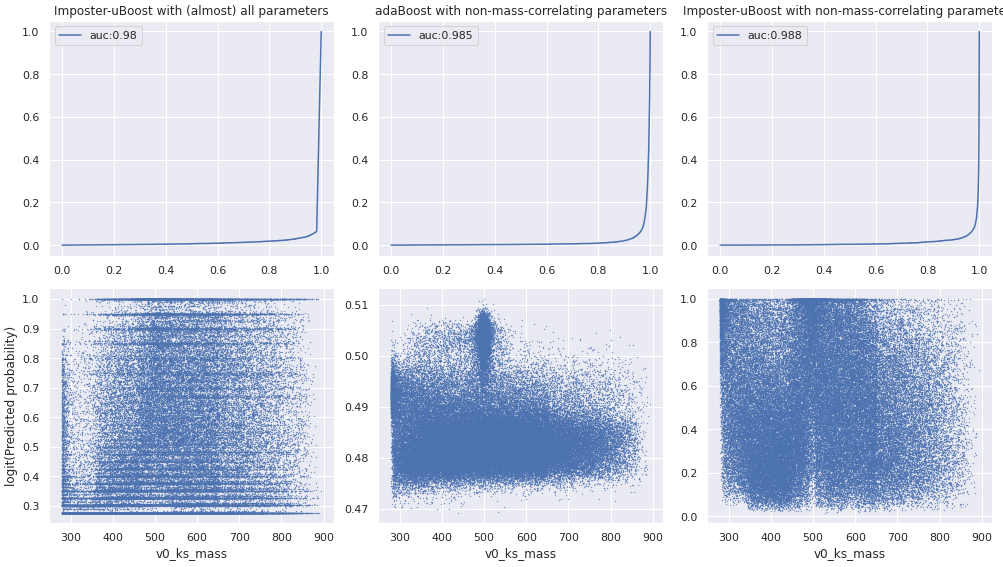

In [21]:
sns.set()
fig, axs = plt.subplots(2,3,figsize=(14,8),sharey = False)
ru = roc_curve(train_labels,probau[:,0])
aucu = roc_auc_score(train_labels,probau[:,0])

axs[0,0].plot(ru[0],ru[1],label = "auc:{:.3}".format(1-aucu))
r = roc_curve(train_labels,proba[:,0])
auc = roc_auc_score(train_labels,proba[:,0])
axs[0,1].plot(r[0],r[1],label = "auc:{:.3}".format(1-auc))

axs[1,0].scatter(test_data["v0_ks_mass"],logit(probau[:,1]),s=0.1)
axs[1,1].scatter(test_data["v0_ks_mass"],proba[:,1],s=0.1)

axs[0,0].set_title("Imposter-uBoost with (almost) all parameters")
axs[0,1].set_title("adaBoost with non-mass-correlating parameters")
axs[0,2].set_title("Imposter-uBoost with non-mass-correlating parameters")

axs[1,0].set_ylabel("logit(Predicted probability)")
axs[1,0].set_xlabel("v0_ks_mass")
axs[1,1].set_xlabel("v0_ks_mass")
axs[1,2].set_xlabel("v0_ks_mass")

rbad = roc_curve(train_labels,probad[:,0])
aucbad = roc_auc_score(train_labels,probad[:,0])
axs[0,2].plot(rbad[0],rbad[1],label = "auc:{:.3}".format(1-aucbad))
axs[1,2].scatter(test_data["v0_ks_mass"],logit(probad[:,1]),s=0.1)
fig.tight_layout()
axs[0,0].legend()
axs[0,1].legend()          
axs[0,2].legend()
              
plt.plot()
sns.reset_orig()

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(15,7))
nnfuncs.roc_curve_data(test_data["v0_ks_mass"],y_pred[:,1],ax_roc=axs[0],ax_fits=axs[1])

# Testing the calculated uncertainty:

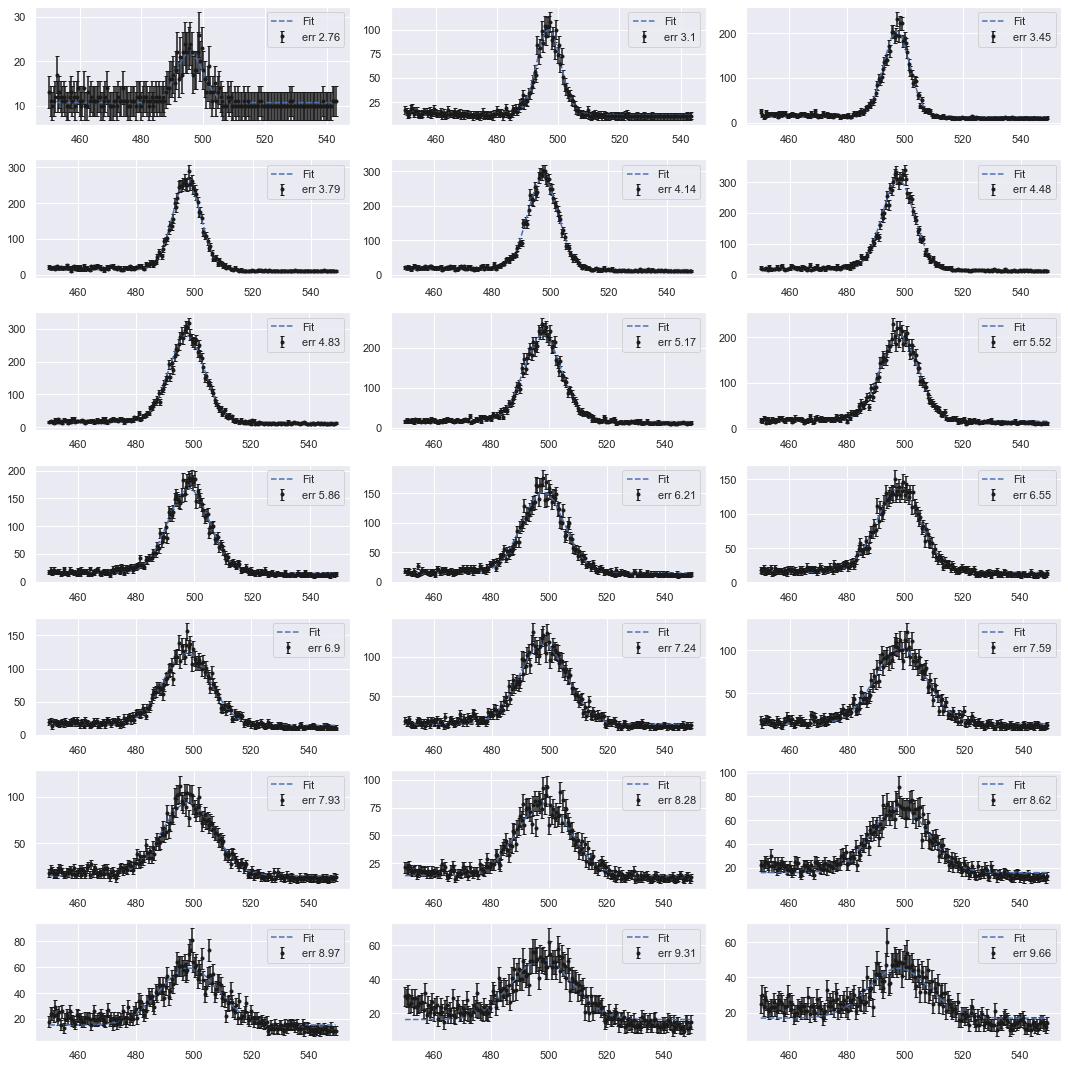

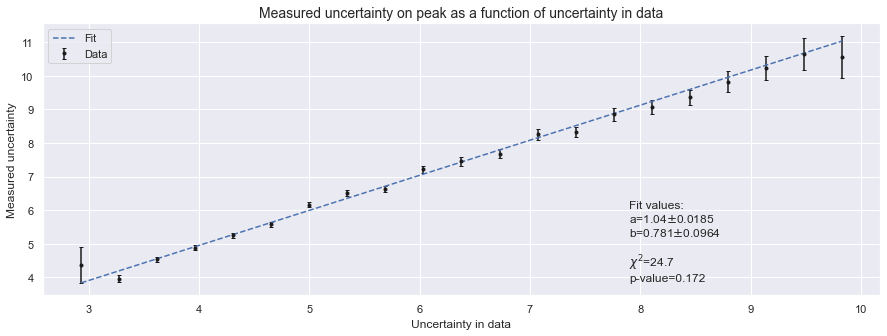

In [43]:
sns.set()

d = truedat
# d = dat


errs = np.linspace(0,10,30)
mis = []
xs = []
cosmask = d["cosTheta"]>0.997

massk = np.logical_and(d["v0_ks_mass"]>450,d["v0_ks_mass"]<550)

msk = np.logical_and(cosmask,massk)
t,f = d["v0_ks_mass"][msk],d["v0_ks_mass"][~msk]

fig, axs = plt.subplots(7,3,figsize=(15,15))
dri = 0
axs=axs.flatten()
for i in range(len(errs)-1):
    rng = np.logical_and(d['v0_ks_massErr']>errs[i],d['v0_ks_massErr']<errs[i+1])
    l = len(t[rng])
    y,x = np.histogram(t[rng],200)
    fffyyy = y
    if(l>100):
#         print(l)
#         xs.append(errs[i])
        bg = lambda x,a,b: x*a+b
        func = lambda x,mu,sigma,a,b: stats.norm.pdf(x,mu,sigma)*a+b

        x = x[:-1]
#         mi,ax = JFuncs.chi2fit(x,y,np.sqrt(y),bg,{"a":10,"b":80},draw=False)
#         y = y.astype(float)-bg(x,*mi.args)
        y -= np.min(y)-10
        if(dri!=16):
            mi, ax = JFuncs.chi2fit(x,y,np.sqrt(y),func,{"mu":494,"sigma":errs[i],"a":100,"b":10},ax=axs[dri],draw=True,label="err {:.3}".format(errs[i]))
        else:
            mi, ax = JFuncs.chi2fit(x,y,np.sqrt(y),func,{"mu":493.5,"sigma":errs[i],"a":100,"b":10},ax=axs[dri],draw=True,label="err {:.3}".format(errs[i]))
        dri+=1
        if mi.migrad_ok():
            mis.append(mi)
            xs.append((errs[i+1]+errs[i])/2)
            
vals = [m.values["sigma"] for m in mis]
verrs = [m.errors["sigma"] for m in mis]
fig.tight_layout()
plt.show()
fig,ax = plt.subplots(figsize=(15,5))
mi, ax = JFuncs.chi2fit(xs,vals,verrs,bg,{"a":1,"b":0},draw=True,ax=ax,text=(0.7,0.05))
plt.title("Measured uncertainty on peak as a function of uncertainty in data",fontsize=14)
# plt.plot(xs,vals,'.')

plt.ylabel("Measured uncertainty")
plt.xlabel("Uncertainty in data")
plt.savefig("fittetuncertainty1.png")
plt.show()

In [7]:
p1 = "cosTheta pT v0_rxyErr v0_rxy v0_chi2 ntrk_pv0 a0 a0xy pv0_y calpha".split(" ")

p2 = "v0_ks_massErr epsilon1 epsilon2 v0_ptErr v0_p v0_pz1 v0_phi2 v0_y".split(" ")

ps = p1+p2

models =[]
tsts =[]

X,Y = dat[ps],dat[["trueKs"]]

X = preprocess(X)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
eval_s = [(X_train, y_train), (X_test, y_test)]
tsts.append(X_train)
model = xgboost.XGBClassifier(learning_rate = 0.01,n_estimators = 200)
model.fit(X_train, y_train,verbose=True,eval_set=eval_s,early_stopping_rounds=30,eval_metric ="auc")
y_pred = model.predict(X_test)
models.append(model)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
results = model.evals_result()

print("Accuracy: {:.3}".format(accuracy * 100.0))
print("AUC: {:.3}".format(np.max(results['validation_0']['auc'])))





[0]	validation_0-auc:0.978647	validation_1-auc:0.97766
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.978776	validation_1-auc:0.97778
[2]	validation_0-auc:0.979044	validation_1-auc:0.978151
[3]	validation_0-auc:0.980097	validation_1-auc:0.979296
[4]	validation_0-auc:0.98009	validation_1-auc:0.979292
[5]	validation_0-auc:0.982018	validation_1-auc:0.98122
[6]	validation_0-auc:0.982152	validation_1-auc:0.981368
[7]	validation_0-auc:0.98215	validation_1-auc:0.981366
[8]	validation_0-auc:0.982194	validation_1-auc:0.981403
[9]	validation_0-auc:0.982384	validation_1-auc:0.98158
[10]	validation_0-auc:0.982398	validation_1-auc:0.981595
[11]	validation_0-auc:0.982411	validation_1-auc:0.981613
[12]	validation_0-auc:0.983747	validation_1-auc:0.983358
[13]	validation_0-auc:0.983758	validation_1-auc:0.983375
[14]	validation_0-auc:0.983832	validation_1-auc:0.983448
[15]

[142]	validation_0-auc:0.989272	validation_1-auc:0.989148
[143]	validation_0-auc:0.989295	validation_1-auc:0.989176
[144]	validation_0-auc:0.989306	validation_1-auc:0.98919
[145]	validation_0-auc:0.989317	validation_1-auc:0.989197
[146]	validation_0-auc:0.989747	validation_1-auc:0.989562
[147]	validation_0-auc:0.989763	validation_1-auc:0.989583
[148]	validation_0-auc:0.989767	validation_1-auc:0.989585
[149]	validation_0-auc:0.989794	validation_1-auc:0.989617
[150]	validation_0-auc:0.989808	validation_1-auc:0.989637
[151]	validation_0-auc:0.989827	validation_1-auc:0.989661
[152]	validation_0-auc:0.989839	validation_1-auc:0.98968
[153]	validation_0-auc:0.989858	validation_1-auc:0.989701
[154]	validation_0-auc:0.989867	validation_1-auc:0.98971
[155]	validation_0-auc:0.989883	validation_1-auc:0.98973
[156]	validation_0-auc:0.989907	validation_1-auc:0.989752
[157]	validation_0-auc:0.98993	validation_1-auc:0.989777
[158]	validation_0-auc:0.989961	validation_1-auc:0.989809
[159]	validation_0-

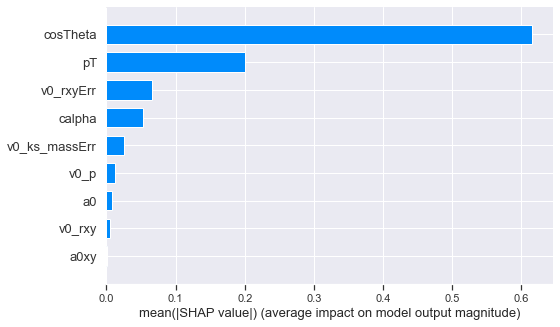

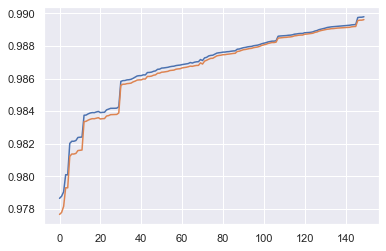

In [135]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X[:1000])
shap.summary_plot(shap_values, X, plot_type="bar",max_display = 9)
plt.show()

plt.plot(results['validation_0']['auc'], label='Train')
plt.plot(results['validation_1']['auc'], label='Train')
# plt.yscale("log")
plt.show()


Test on real data

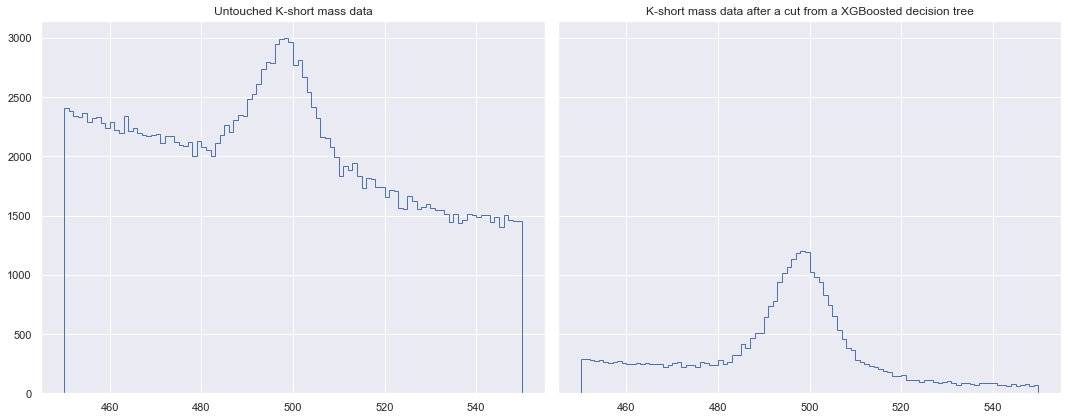

In [8]:
sns.set()

d = truedat[:int(1e6)]

y_pred = model.predict_proba(preprocess(d[ps]))
dpred = d[y_pred[:,0]<0.4]

# dpred = dpred[np.logical_and(dpred["v0_ks_mass"]>450,dpred["v0_ks_mass"]<550)]
c =npand(d["v0_ks_mass"]>450,d["v0_ks_mass"]<550)
d = d[c]
dpred = dpred[c]

fig,axs = plt.subplots(1,2,figsize=(15,6),sharey=True)
hist(d["v0_ks_mass"],ax = axs[0])
hist(dpred["v0_ks_mass"],ax=axs[1])

axs[0].set_title("Untouched K-short mass data")
axs[1].set_title("K-short mass data after a cut from a XGBoosted decision tree")
plt.savefig("cutbyML.png")
plt.tight_layout()

Completed fit with Chi2: 95.1, p-val: 0.363 and the total amount of signal 18763 +/- 376, background: 981238
No valid minimum found!
Completed fit with Chi2: 79.4, p-val: 0.803 and the total amount of signal 2127 +/- 10216, background: 897874
Completed fit with Chi2: 70.0, p-val: 0.950 and the total amount of signal 639 +/- 200, background: 799361
No valid minimum found!
Completed fit with Chi2: 78.9, p-val: 0.813 and the total amount of signal 73 +/- 17598, background: 699927
Completed fit with Chi2: 70.1, p-val: 0.949 and the total amount of signal 8 +/- 13, background: 599992
Completed fit with Chi2: 74.2, p-val: 0.900 and the total amount of signal 0 +/- nan, background: 500000
Completed fit with Chi2: 82.1, p-val: 0.738 and the total amount of signal 0 +/- 0, background: 400000
Completed fit with Chi2: 87.2, p-val: 0.594 and the total amount of signal 78 +/- 79, background: 299923
Completed fit with Chi2: 87.2, p-val: 0.593 and the total amount of signal 35 +/- 59, background: 199

-0.058006384659226896

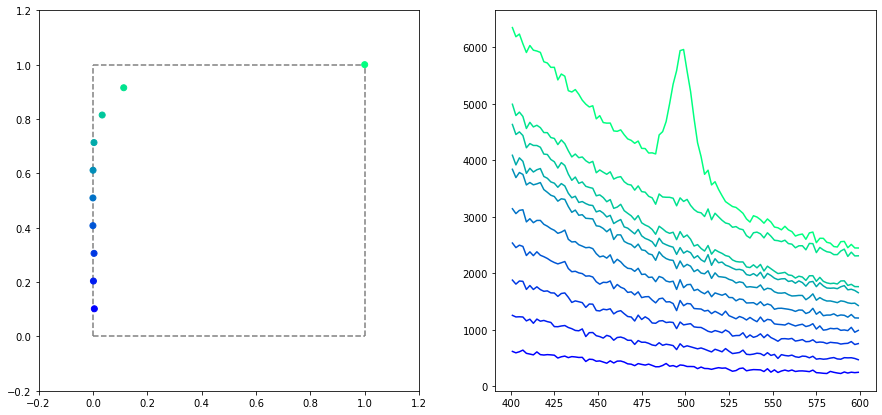

In [26]:
fig, axs = plt.subplots(1,2,figsize=(15,7))
nnfuncs.roc_curve_data(d["v0_ks_mass"],y_pred[:,0],ax_roc=axs[0],ax_fits=axs[1])

In [134]:
size = int(1e6)
d = df_all[:int(size)]
dtrain = d[:int(1.5/2*size)]
dtest = d[int(1.5/2*size):]
d = dtrain
print(dtest.shape)
mcut = npand(dtest["v0_la_mass"]<1160,dtest["v0_la_mass"]>1000)
dtest = dtest[mcut]

d = preprocess(d)
cs = [c for c in d.columns]
cs = cs[:-15]
cs = cs[:cs.index("v0_la_mass"):]
X,y = d[cs],d[["trueLa"]]

model = xgboost.XGBClassifier(learning_rate = 0.01,n_estimators = 100,verbose_eval=5)
model.fit(X, y,eval_metric ="auc")

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, plot_type="bar")

p = model.predict_proba(dtest[cs])


hist(dtest["v0_la_mass"],100)
hist((dtest[p[:,0]<0.8])["v0_la_mass"],100)


(250000, 155)


MemoryError: Unable to allocate 887. MiB for an array with shape (155, 750000) and data type float64